**Description:** This notebook is used to how diffrent methods score on the raw dataset. We just use the basic and needed preprocesssing (scaler and encoder) and tried a few. Later on we added an artificial neural network on a slightly diffretn dataset. This notebook is just to get an impression and see the performances.

**Project Name:** Baseline models

**Team:** Carlotta Ulm, Silas Mederer, Jonas Bechthold

**Date:** 2020-10-26 to 2020-11-27

# Base model supervised learning

In [3]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import math
import IPython

# own modules
import eda_methods as eda

# visualization
import seaborn as sns
sns.set(style="white")  
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from pandas.plotting import scatter_matrix

# warnings handler
import warnings
warnings.filterwarnings("ignore")

# Machine Learning Libraries
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import fbeta_score, accuracy_score, f1_score, recall_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer 
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Pipeline
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

## Load data

In [3]:
df = pd.read_csv('data/f_chtr_churn_traintable_nf_2.csv')
df.drop("Unnamed: 0", axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209043 entries, 0 to 209042
Columns: 170 entries, auftrag_new_id to date_x
dtypes: float64(32), int64(120), object(18)
memory usage: 271.1+ MB


## Check

In [3]:
null_rel = round(df.isin([0]).sum() / df.shape[0]*100,2)
null_rel = null_rel.to_frame()
null_rel.rename(columns={0: "zeros %"}, inplace=True)

In [4]:
eda.meta(df).T.join(null_rel).head()

,nulls,percent,dtype,dup,nuniques,zeros %
varname,,,,,,
kuendigungs_eingangs_datum,142754,68.29,object,True,349,0.00
ort,85,0.04,object,True,11475,0.00
email_am_kunden,12,0.01,float64,True,2,6.43
auftrag_new_id,0,0,object,False,209043,0.00
openrate_produktnews_1w,0,0,float64,True,10,98.43


In [5]:
print(f"shape {df.shape}")
continues = df.select_dtypes(include=['float64','int64'])
print(f"numeric features {len(continues.columns)}")
categorial = df.select_dtypes(include="object")
print(f"object features   {len(categorial.columns)}")

shape (209043, 170)
numeric features 152
object features   18


For further information about the data, check the [EDA Notebook](https://github.com/jb-ds2020/nf-ds3-capstone-churn-prevention/blob/main/Capstone_Zeit_EDA.ipynb)

## Check for correleations

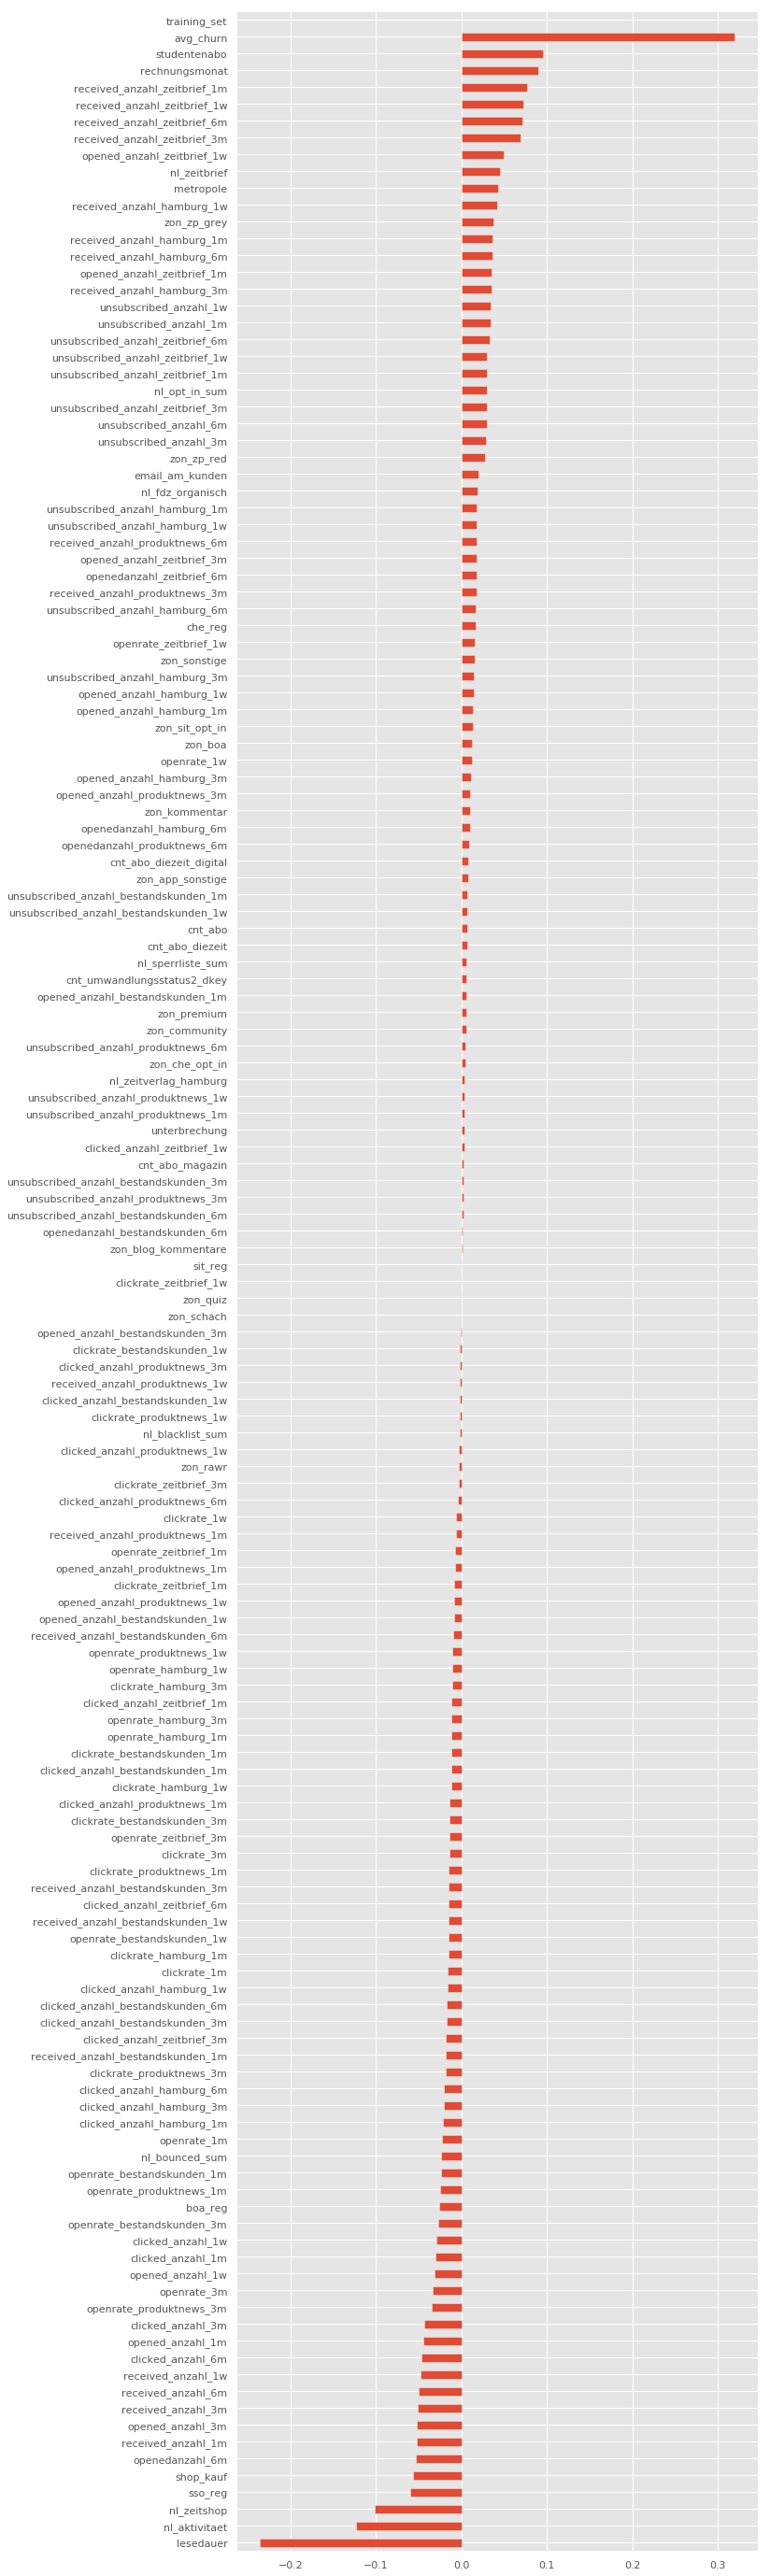

In [6]:
df.drop('churn', axis=1).corrwith(df.churn).sort_values().plot(kind='barh',figsize=(10, 50));

## Drop features

In [7]:
print(df.shape)
df.drop(["auftrag_new_id", "avg_churn", "ort", "date_x", "kuendigungs_eingangs_datum", "abo_registrierung_min", "training_set"], axis=1, inplace=True)
print(df.shape)

(209043, 170)
(209043, 163)


## Sample & split

In [8]:
# calculate sample size for 1% and 10%
twenty_percent = df.sample(int(round(len(df) / 5)))
print(twenty_percent.shape)
twenty_percent.head()

(41809, 163)


,liefer_beginn_evt,kanal,objekt_name,aboform_name,zahlung_rhythmus_name,lesedauer,rechnungsmonat,zahlung_weg_name,studentenabo,plz_1,...,unsubscribed_anzahl_zeitbrief_1m,unsubscribed_anzahl_zeitbrief_3m,unsubscribed_anzahl_zeitbrief_6m,openrate_zeitbrief_1w,clickrate_zeitbrief_1w,openrate_zeitbrief_1m,clickrate_zeitbrief_1m,openrate_zeitbrief_3m,clickrate_zeitbrief_3m,churn
142760,2018-02-15,Telefonmarketing,DIE ZEIT,Festabo,vierteljährlich,25,0,Rechnung,0,2,...,0,0,0,0.5,0.0,0.6,0.0,0.92,0.0,1
95294,2018-04-26,E-Mailing,DIE ZEIT,Probeabo,jährlich,23,0,Bankeinzug,0,2,...,0,0,0,0.0,0.0,0.0,0.0,0.00,0.0,0
100425,2017-05-04,Telefonmarketing,ZEIT Digital,Festabo,jährlich,32,0,Bankeinzug,0,5,...,0,0,0,0.0,0.0,0.0,0.0,0.00,0.0,1
37221,2013-05-29,andere,DIE ZEIT,Festabo,jährlich,84,0,Bankeinzug,0,3,...,0,0,0,0.0,0.0,0.0,0.0,0.08,0.0,0
22972,2013-02-07,andere,DIE ZEIT,Probeabo,jährlich,86,0,Rechnung,0,4,...,0,0,0,0.0,0.0,0.0,0.0,0.08,1.0,0


In [5]:
y = df['churn']
X = df.drop('churn', axis = 1)
X.shape

(209043, 169)

## Pipeline

In [13]:
def pipeline(X,y):
    
    # devide features
    categoric_features = list(X.columns[X.dtypes==object])
    categoric_features

    numeric_features = list(X.columns[X.dtypes != object])
    numeric_features

    # split train and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

    # defining the models
    models = [
        LogisticRegression(n_jobs=-1),
        KNeighborsClassifier(),
        SVC(),
        DecisionTreeClassifier(),
        RandomForestClassifier(n_jobs=-1), 
        XGBClassifier(n_jobs=-1),
        AdaBoostClassifier()
    ]

    # create preprocessors
    numeric_transformer = Pipeline(steps=[
            ('imputer_num', SimpleImputer(missing_values=np.nan, strategy='mean')),
            ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
            ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categoric_features)
        ])


    # process pipeline for every model
    for model in models:
        print(f"\n " + str(model))
        pipe = Pipeline(steps=[('preprocessor', preprocessor), 
                               ('classifier', model)
                               ])

        # fit model
        pipe.fit(X_train, y_train)  

        #predict results
        y_train_pred = cross_val_predict(pipe, X_train, y_train, cv=5)
        y_test_pred = pipe.predict(X_test)

        # print results
        # print("\nResults on training data: ")
        # print(classification_report(y_train, y_train_pred))
        print("\nResults on test data:")
        print(classification_report(y_test, y_test_pred))
        # print("\nConfusion matrix on test")
        # print(confusion_matrix(y_test, y_test_pred))
        # print("\n")

        # plot heatmap
        conf_mat = pd.crosstab(np.ravel(y_train), np.ravel(y_train_pred),
                               colnames=["Predicted"], rownames=["Actual"])
        sns.heatmap(conf_mat/np.sum(conf_mat), annot=True, cmap="Blues", fmt=".2%")
        plt.show()
        plt.close()
    
    # print balance and sizes
    print ("Testing set has {} features.".format(X_test.shape[1]))
    eda.plot_train_test_split(y,y_train,y_test)

We used a list of most common calssifiers, just to geht an impression of their performance on the dataset. We will use the Logistic Regression as a base model. The Zeitverlag Hamburg uses one like these in theit churn prevention. Also we need the overview to find the models that could handle our dataset and will improve them to use them for our best solution. These are the models: 
- LogisticRegression(n_jobs=-1),
- KNeighborsClassifier(),
- SVC(),
- DecisionTreeClassifier(),
- RandomForestClassifier(n_jobs=-1), 
- XGBClassifier(n_jobs=-1),
- AdaBoostClassifier)

## Results


 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=None, solver='warn', tol=0.0001,
          verbose=0, warm_start=False)

Results on test data:
              precision    recall  f1-score   support

           0       0.79      0.92      0.85     35702
           1       0.74      0.48      0.58     16559

   micro avg       0.78      0.78      0.78     52261
   macro avg       0.77      0.70      0.72     52261
weighted avg       0.78      0.78      0.77     52261



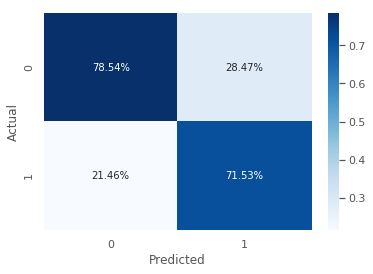


 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

Results on test data:
              precision    recall  f1-score   support

           0       0.77      0.84      0.81     35702
           1       0.58      0.46      0.51     16559

   micro avg       0.72      0.72      0.72     52261
   macro avg       0.67      0.65      0.66     52261
weighted avg       0.71      0.72      0.71     52261



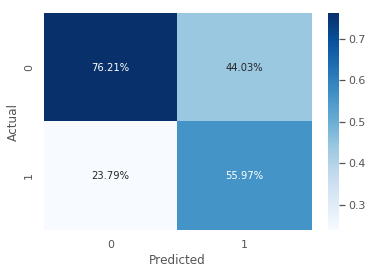


 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

Results on test data:
              precision    recall  f1-score   support

           0       0.69      1.00      0.81     35702
           1       0.93      0.01      0.02     16559

   micro avg       0.69      0.69      0.69     52261
   macro avg       0.81      0.50      0.42     52261
weighted avg       0.76      0.69      0.56     52261



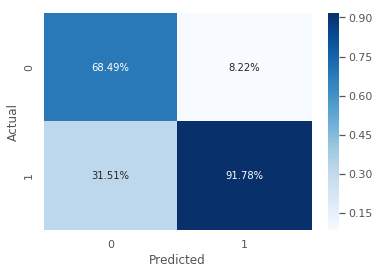


 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Results on test data:
              precision    recall  f1-score   support

           0       0.84      0.87      0.86     35702
           1       0.70      0.64      0.67     16559

   micro avg       0.80      0.80      0.80     52261
   macro avg       0.77      0.76      0.76     52261
weighted avg       0.80      0.80      0.80     52261



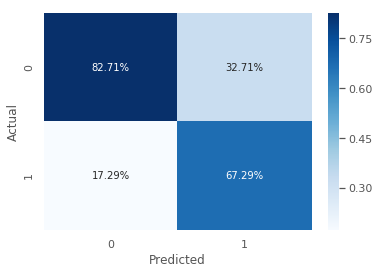


 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Results on test data:
              precision    recall  f1-score   support

           0       0.80      0.95      0.87     35702
           1       0.83      0.48      0.61     16559

   micro avg       0.80      0.80      0.80     52261
   macro avg       0.81      0.72      0.74     52261
weighted avg       0.81      0.80      0.79     52261



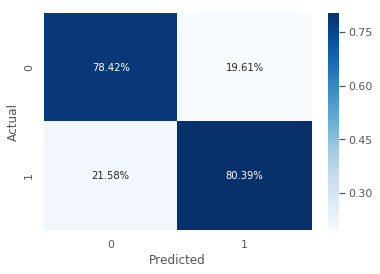


 XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
       colsample_bynode=None, colsample_bytree=None, gamma=None,
       gpu_id=None, importance_type='gain', interaction_constraints=None,
       learning_rate=None, max_delta_step=None, max_depth=None,
       min_child_weight=None, missing=nan, monotone_constraints=None,
       n_estimators=100, n_jobs=-1, num_parallel_tree=None,
       objective='binary:logistic', random_state=None, reg_alpha=None,
       reg_lambda=None, scale_pos_weight=None, subsample=None,
       tree_method=None, validate_parameters=None, verbosity=None)

Results on test data:
              precision    recall  f1-score   support

           0       0.79      0.92      0.85     35702
           1       0.72      0.47      0.57     16559

   micro avg       0.78      0.78      0.78     52261
   macro avg       0.76      0.69      0.71     52261
weighted avg       0.77      0.78      0.76     52261



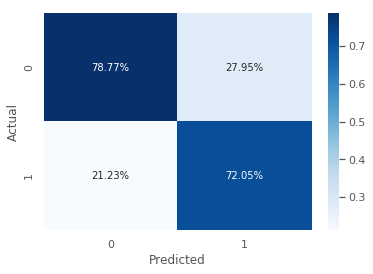


 AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

Results on test data:
              precision    recall  f1-score   support

           0       0.76      0.90      0.83     35702
           1       0.65      0.39      0.48     16559

   micro avg       0.74      0.74      0.74     52261
   macro avg       0.70      0.64      0.65     52261
weighted avg       0.72      0.74      0.72     52261



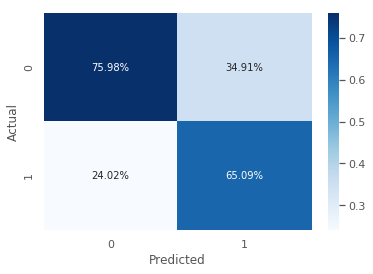

Testing set has 162 features.
Training set has 156782 samples.
Testing set has 52261 samples.


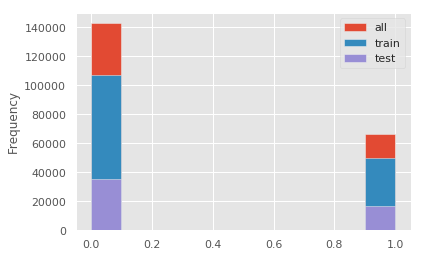

In [14]:
pipeline(X,y)

# Base model unsupervised learning: Artificial Neural Network

In [1]:
# ANN
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, Flatten
from keras.metrics import Recall, Precision
from keras.callbacks import TensorBoard

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

Using TensorFlow backend.


## Data preperation

In [5]:
df = pd.read_csv('data/df_clean_engineered_all.csv')
y = df['churn']
df = df.drop(['churn','plz_3','abo_registrierung_min','nl_registrierung_min','ort'], axis = 1)
X = pd.get_dummies(df, columns = ['kanal', 'objekt_name', 'aboform_name', 'zahlung_rhythmus_name',
                                   'zahlung_weg_name', 'plz_1', 'plz_2', 'land_iso_code', 
                                   'anrede','titel'], drop_first = True)

In [6]:
# devide features
categoric_features = list(X.columns[X.dtypes==object])
numeric_features = list(X.columns[X.dtypes != object])

# split train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1,stratify=y)

#create preprocessors
numeric_transformer = Pipeline(steps=[
    ('imputer_num', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
    #('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
        ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categoric_features)
])

In [7]:
preprocessor.fit(X_train)
X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)

## Setup: ANN

In [8]:
units = int((X.shape[1] + 1) / 2)
input_dim = X.shape[1]
print(units)
print(input_dim)

154
307


In [9]:
cb_epoch_dots = tfdocs.modeling.EpochDots(report_every=100)
Recall = tf.keras.metrics.Recall(name='recall')
Precision = tf.keras.metrics.Precision(name='precision')
Loss = tf.keras.losses.BinaryCrossentropy(name='binary_crossentropy')

In [10]:
nn = Sequential()
nn.add(Dense(units, input_dim=input_dim, activation='relu'))
nn.add(Dense(units,activation='relu'))
nn.add(Dense(1, activation='sigmoid'))
nn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 154)               47432     
_________________________________________________________________
dense_2 (Dense)              (None, 154)               23870     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 155       
Total params: 71,457
Trainable params: 71,457
Non-trainable params: 0
_________________________________________________________________


It is very common to use the formular: (features + 1)/2 to calculate the neuron number. So we will use an ANN with 154 neurons input layer, 154 hidden layer and one output. Adam is the basic optimizer and the combination relu, relu, sigmoid is the most recommended combination of activation functions we could find for binary classification.

In [11]:
adam = tf.keras.optimizers.Adam()
nn.compile(loss="binary_crossentropy", 
           optimizer=adam, 
           metrics=[Loss, Recall, Precision, 'accuracy'])

nn_history = nn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1000, 
                    batch_size=1024, callbacks=[cb_epoch_dots],verbose=0)


Epoch: 0, accuracy:0.7275,  binary_crossentropy:0.5474,  loss:0.5473,  precision:0.5537,  recall:0.2030,  val_accuracy:0.7350,  val_binary_crossentropy:0.5368,  val_loss:0.5369,  val_precision:0.6048,  val_recall:0.3016,  
...................................................................................................
Epoch: 100, accuracy:0.8683,  binary_crossentropy:0.3110,  loss:0.3112,  precision:0.7397,  recall:0.5835,  val_accuracy:0.7655,  val_binary_crossentropy:0.5875,  val_loss:0.5866,  val_precision:0.7399,  val_recall:0.5839,  
....................................................................................................
Epoch: 200, accuracy:0.9028,  binary_crossentropy:0.2419,  loss:0.2415,  precision:0.7681,  recall:0.6474,  val_accuracy:0.7695,  val_binary_crossentropy:0.7064,  val_loss:0.7043,  val_precision:0.7683,  val_recall:0.6476,  
....................................................................................................
Epoch: 300, accuracy:0.9

### Evaluation

In [12]:
y_pred_proba = nn.predict(X_test)
y_pred = (y_pred_proba > 0.5)

In [13]:
conf_matrix = confusion_matrix(y_test, y_pred)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.81      0.83     32170
           1       0.60      0.65      0.63     13995

    accuracy                           0.76     46165
   macro avg       0.72      0.73      0.73     46165
weighted avg       0.77      0.76      0.77     46165



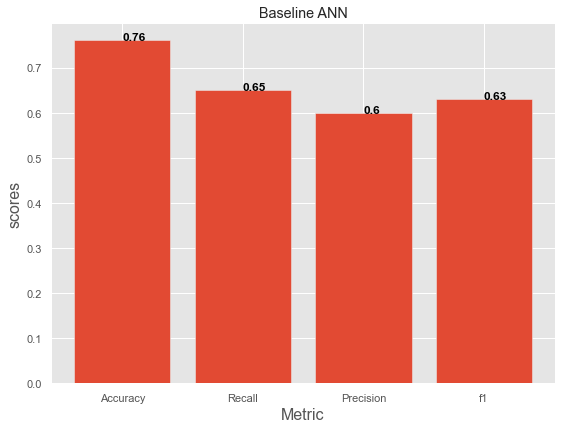

In [17]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_axes([0,0,1,1])
metrics = ['Accuracy', 'Recall', 'Precision', 'f1']
scores = [0.76, 0.65, 0.60, 0.63]
ax.bar(metrics, scores)
ax.set_ylabel('scores',fontsize= 16)
ax.set_xlabel('Metric',fontsize= 16)
ax.set_title('Baseline ANN')
for i, v in enumerate(scores):
    ax.text( i ,v, str(v), color='black', fontweight='bold', fontsize=12)
plt.show()

array([[26064,  6106],
       [ 4857,  9138]])

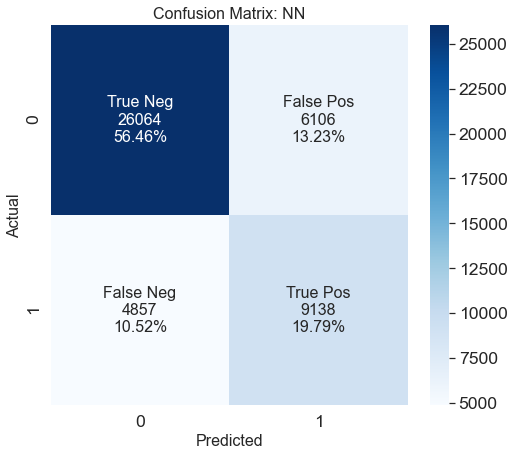

In [18]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                conf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     conf_matrix.flatten()/np.sum(conf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.set(font_scale=1.6)
fig, ax = plt.subplots(figsize=(8,7)) 
sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues',annot_kws={"size": 16})
plt.title('Confusion Matrix: NN', fontsize = 16); # title with fontsize 20
plt.xlabel('Predicted', fontsize = 16);
plt.ylabel('Actual', fontsize = 16);
conf_matrix

### Plots over epochs

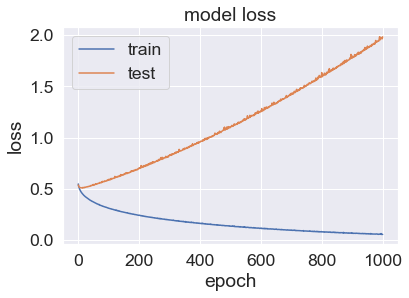

In [19]:
plt.plot(nn_history.history['loss']) 
plt.plot(nn_history.history['val_loss']) 
plt.title('model loss') 
plt.ylabel('loss')
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='upper left') 
plt.show()

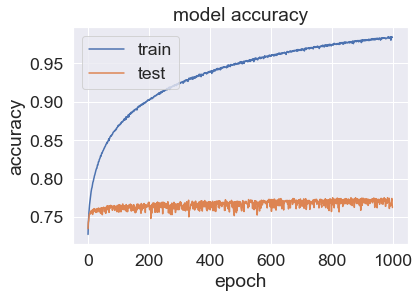

In [20]:
plt.plot(nn_history.history['accuracy']) 
plt.plot(nn_history.history['val_accuracy']) 
plt.title('model accuracy') 
plt.ylabel('accuracy')
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='upper left') 
plt.show()

Here we can see that our model tends to overfitting. The discrepancy between train (red) and test (blue) is around 25%. That needs to be reduced. 

### Plot ANN

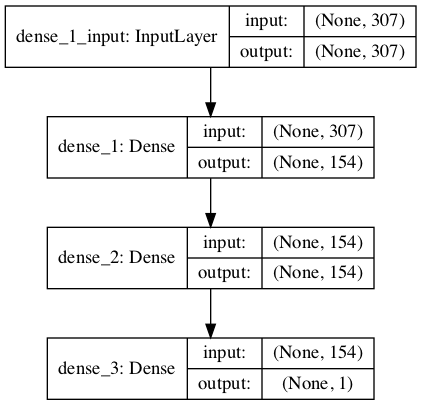

In [21]:
from keras.utils.vis_utils import plot_model
plot_model(nn, show_shapes=True, show_layer_names=True)